# 针对PHONIX实验组的 $v_n$ 测量的计算

## Fitting dNdEta Distribution $n_{BC}$ Depandence $\Delta \eta$ 

## 熵密度分布的形式

### $$
% \begin{equation}
\begin{split}
e(\mathbf{x}_{\perp},\eta)
&=f_L(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \alpha}\\
&+f_R(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \alpha}\\
&+ F_{L,R}(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \beta}
\end{split}
% \end{equation}
$$

### $$F_{L,R}(\eta)=\left\{\begin{array}{ll}1,&\mathrm{if} |\eta|\leq\eta_\mathrm{flat}\\\exp\biggl(-\frac{(|\eta|-\eta_\mathrm{flat})^2}{2\eta_\mathrm{gw}^2}\biggr),&\mathrm{if} |\eta|>\eta_\mathrm{flat}\end{array}\right.$$

### $$f_{L,R}(\eta) = \exp\left(-\frac{(|\eta| \pm \eta_0)^2}{2 \sigma^2}\right)$$

### 这里 $f_L(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为左侧向右侧运动的d核的纵向分布函数；  
### $f_R(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为右侧向左侧运动的Au核的纵向分布函数

# 一、定义计算熵的类，对每个事件添加一个$n_{BC}^{i}$依赖的快度损失
### $$\Delta \eta_{i}= \frac{n_{BC}^{i}-n_{BC}^{min}}{n_{BC}^{max}-n_{BC}^{min}} + 2$$

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
hep.style.use('ATLAS')
import os

# 导入实验数据

In [2]:
def read_vn_data(file_path, start_row=8, end_row=18):
    """
    读取d+Au碰撞的v2数据（精确控制行范围）
    
    参数:
        file_path: 文件路径
        start_row: 数据开始行号（从0开始计数，跳过注释行）
        end_row: 数据结束行号（不包含）
    
    返回:
        DataFrame包含列:
        PT, PT_LOW, PT_HIGH, v2, stat_plus, stat_minus, sys_plus, sys_minus
    """
    # 读取指定行范围数据（制表符分隔）
    df = pd.read_csv(file_path,skiprows=start_row,nrows=end_row-start_row,header=None,)
    
    # 列命名（根据图片中的数据格式）
    df.columns = [
        'pT', 'pT_low', 'pT_high', 'vn', 
        'stat_plus', 'stat_minus', 'sys_plus', 'sys_minus'
    ]
    
    # 数据清洗（去除可能的空值）
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return df

In [3]:
# 读取中心度的数据
v2 = read_vn_data(file_path='./data/HEPData_dAu_v2pT_0-5.csv', start_row=9, end_row=19)
# 读取中心度的数据
v3 = read_vn_data(file_path='./data/HEPData_dAu_v3pT_0-5.csv', start_row=9, end_row=19)


In [4]:
v3

,pT,pT_low,pT_high,vn,stat_plus,stat_minus,sys_plus,sys_minus
0,0.50,0.4,0.6,0.0019,0.0011,-0.0011,0.0009,-0.0008
1,0.70,0.6,0.8,0.0055,0.0014,-0.0014,0.0025,-0.0023
2,0.95,0.9,1.0,0.0073,0.0018,-0.0018,0.0034,-0.0031
3,1.10,1.0,1.2,0.0095,0.0023,-0.0023,0.0045,-0.0040
4,1.30,1.2,1.4,0.0138,0.0029,-0.0029,0.0066,-0.0059
5,1.50,1.4,1.6,0.0168,0.0037,-0.0037,0.0080,-0.0072
6,1.70,1.6,1.8,0.0141,0.0046,-0.0046,0.0068,-0.0060
7,1.90,1.8,2.0,0.0153,0.0058,-0.0058,0.0074,-0.0065
8,2.25,2.0,2.5,0.0191,0.0053,-0.0053,0.0094,-0.0081
9,2.75,2.5,3.0,0.0174,0.0088,-0.0088,0.0088,-0.0074


In [5]:
def plot_exp_data(data, label_text, color, mark):
    """
    绘制实验数据。

    :param data: 数据
    :param title: 图形标题
    :param color: 颜色
    """
    # 计算误差
    data['total_error_plus'] = np.sqrt(data['stat_plus']**2 + data['sys_plus']**2)
    data['total_error_minus'] = np.sqrt(data['stat_minus']**2 + data['sys_minus']**2)
    # 画图
#     plt.figure(figsize=(8, 4))  # 宽度为8英寸，高度为6英寸
    plt.errorbar(data['pT'], data['vn'], yerr=[data['total_error_minus'], data['total_error_plus']], fmt=mark, color=color, ecolor=color, capsize=3, label=label_text)
    plt.legend(fontsize=20)

In [6]:
def plot_vn_pT(m=0, n=20, eta_flat='1p0', eta_gw='1p3', event_range=[0, 300],
               para="entropy3D_y0_3p5_sigma_3p0_L_factor_2p5_R_factor_2p5_P_factor_5p0_alpha_1p0_beta_0p5_y_loss_0p0",
               nsampling=2000,fontsize=16, plot_errbar=True,
               HWF_or_DWF='HWF', color='blue'):
    """
    优化后的绘制 dN/dη 图的函数，适用于所有事件数据横坐标相同的情况。
    - 只需对所有事件的纵坐标求平均即可。
    """
    
    # 文件路径和文件名
    input_dir = f"/media/mengzhu/west16/d_Au_work2/d_Au_{HWF_or_DWF}/hydro_result_n_BC/ebe_mc_nsampling_{nsampling}/plat_{eta_flat}_gw_{eta_gw}/{para}/dAu200/{m}_{n}/"
    input_filename = "vn_mc_charged.dat"

    # 初始化变量
    all_data = []
    event_count = 0

    # 遍历文件并加载数据
    for i in range(event_range[0], event_range[1]):
        input_path = os.path.join(input_dir, f"event{i}", input_filename)
        try:
            vn_pT = np.loadtxt(input_path)
            if len(all_data) == 0:  # 初始化 all_data
                all_data = vn_pT[:, 1]  # 只存储纵坐标
                x_values = dNdEta[:, 0]  # 横坐标（假设所有事件相同）
            else:
                all_data += dNdEta[:, 1]  # 累加纵坐标
            event_count += 1
        except Exception as e:
            print(f"无法处理文件 {input_path}: {e}")

    # 确保有数据可用
    if event_count > 0:
        # 计算平均值和标准误差
        bin_means = all_data / event_count  # 平均值
#         std_error = np.sqrt(all_data / event_count) / np.sqrt(event_count)  # 标准误差（假设泊松分布）
        std_error = 1 / np.sqrt(event_count)  # 标准误差（假设泊松分布）
        

        # 绘图
#         plt.figure(figsize=(8, 4))  # 宽度为8英寸，高度为6英寸
        if plot_errbar:
            plt.errorbar(x_values, bin_means, yerr= std_error*bin_means, fmt='-', color=color)
        else:
            plt.plot(x_values,  bin_means, color=color)

        plt.xlabel(r"$\rm \eta$", fontsize=fontsize, ha='center')
        plt.ylabel(r"$\rm dN/d\eta$", fontsize=fontsize, ha='center')

        plt.xlim(-6, 6)
    else:
        print("没有找到可处理的文件。")


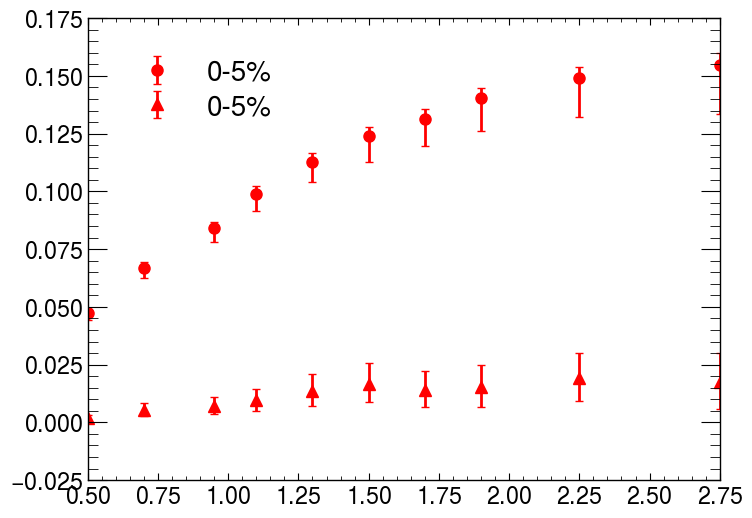

In [7]:
plot_exp_data(data=v2,label_text="0-5%",color="red",mark="o")
plot_exp_data(data=v3,label_text="0-5%",color="red",mark="^")



In [17]:
def plot_vn_pT(m=0, n=20, eta_flat='1p0', eta_gw='1p3', event_range=[0, 300],
               para="entropy3D_y0_3p5_sigma_3p0_L_factor_2p5_R_factor_2p5_P_factor_5p0_alpha_1p0_beta_0p5_y_loss_0p0",
               nsampling=2000, fontsize=16, plot_errbar=True,
               HWF_or_DWF='HWF', colors=['blue', 'red']):
    """
    绘制 vn(pT) 图，处理多个事件的统计平均
    
    参数:
        m, n: 事件编号范围参数
        event_range: 事件编号范围 [start, end)
        colors: [v2颜色, v3颜色]
    """
    # 文件路径配置
    input_dir = f"/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}/hydro_result_n_BC/ebe_mc_nsampling_{nsampling}/plat_{eta_flat}_gw_{eta_gw}/{para}/dAu200/{m}_{n}/"
    input_filename = "vn_mc_charged.dat"

    # 初始化存储数组
    all_v2 = []
    all_v3 = []
    pT_values = None
    event_count = 0

    # 遍历事件文件
    for i in range(event_range[0], event_range[1]):
        input_path = os.path.join(input_dir, f"event{i}", input_filename)
        try:
            data = np.loadtxt(input_path)
            if pT_values is None:  # 第一次读取时获取pT值
                pT_values = data[:, 0]
            
            # 存储v2和v3数据 (列顺序: pT, v1, v2, v3, ...)
            all_v2.append(data[:, 2])  # 第三列是v2
            all_v3.append(data[:, 3])  # 第四列是v3
            event_count += 1
        except Exception as e:
            print(f"跳过事件 {i}: {str(e)}")

    if event_count == 0:
        print("错误: 没有有效数据!")
        return

    # 转换为numpy数组便于计算
    all_v2 = np.array(all_v2)
    all_v3 = np.array(all_v3)

    # 计算平均值和标准误差
    v2_mean = np.mean(all_v2, axis=0)
    v3_mean = np.mean(all_v3, axis=0)
    v2_err = np.std(all_v2, axis=0) / np.sqrt(event_count)  # 标准误差
    v3_err = np.std(all_v3, axis=0) / np.sqrt(event_count)

    # 创建图形
    plt.figure(figsize=(8, 6))

    # 绘制v2
    if plot_errbar:
        plt.errorbar(pT_values, v2_mean, yerr=v2_err, 
                    fmt='o-', color=colors[0], 
                    markersize=5, capsize=3,
                    label=r'$v_2$')
    else:
        plt.plot(pT_values, v2_mean, 'o-', color=colors[0], label=r'$v_2$')

    # 绘制v3
    if plot_errbar:
        plt.errorbar(pT_values, v3_mean, yerr=v3_err, 
                    fmt='s--', color=colors[1],
                    markersize=5, capsize=3,
                    label=r'$v_3$')
    else:
        plt.plot(pT_values, v3_mean, '^--', color=colors[1], label=r'$v_3$')

    # 图表装饰
    plt.xlabel(r'$p_T$ (GeV/c)', fontsize=fontsize,ha='center')
    plt.ylabel(r'$v_n$', fontsize=fontsize,ha='center')
    plt.title(f'Flow Coefficients vs $p_T$ ({event_count} events)', fontsize=fontsize+2)
    plt.legend(fontsize=fontsize-2)
#     plt.grid(True, linestyle='--', alpha=0.6)
    
    # 坐标轴范围
#     plt.xlim(0, max(pT_values)*1.1)
#     vn_max = max(np.max(v2_mean + v2_err), np.max(v3_mean + v3_err))
#     plt.ylim(0, vn_max*1.2)
    plt.xlim(0, 3)
    plt.ylim(0, 0.2)
    


    plt.tight_layout()
#     plt.show()



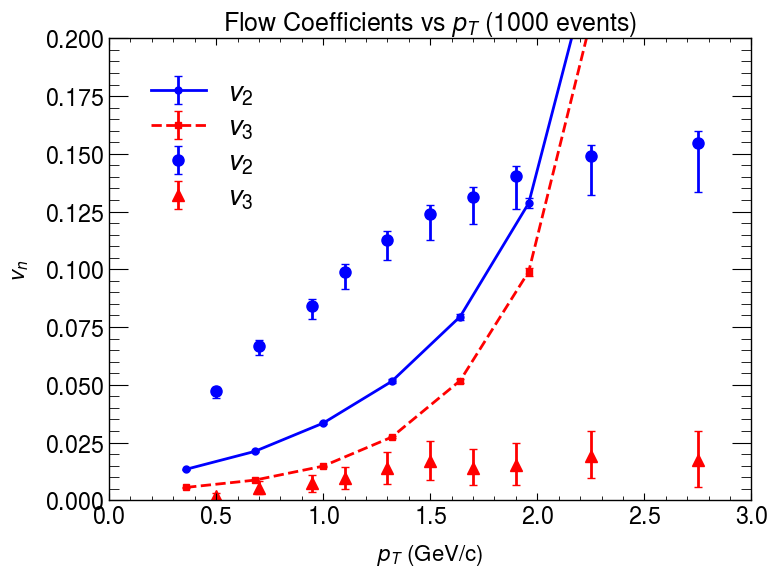

In [18]:
plot_vn_pT(m=0, n=5, eta_flat='1p3', eta_gw='1p3', event_range=[0, 1000],
                para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35",
                nsampling=4000,fontsize=16, 
                HWF_or_DWF='DWF')
plot_exp_data(data=v2,label_text="$v_2$",color="blue",mark="o")
plot_exp_data(data=v3,label_text="$v_3$",color="red",mark="^")

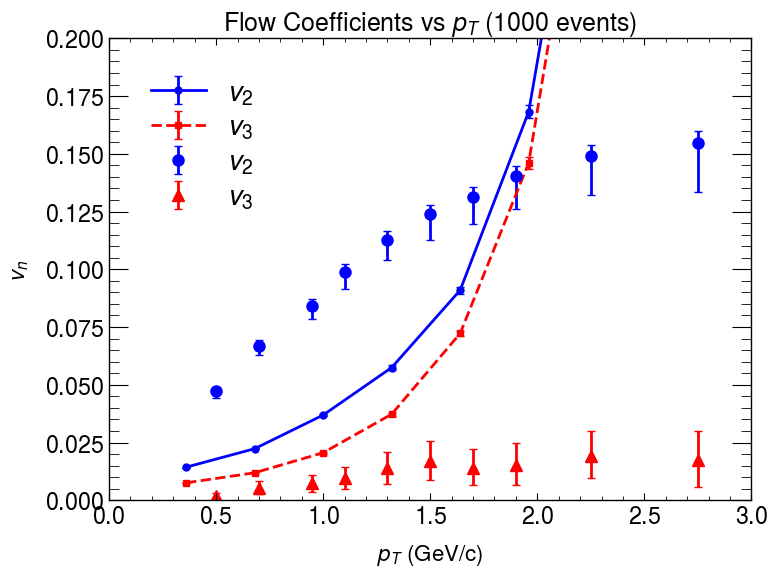

In [19]:
plot_vn_pT(m=0, n=5, eta_flat='1p3', eta_gw='1p3', event_range=[0, 1000],
                para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35",
                nsampling=2000,fontsize=16, 
                HWF_or_DWF='DWF')
plot_exp_data(data=v2,label_text="$v_2$",color="blue",mark="o")
plot_exp_data(data=v3,label_text="$v_3$",color="red",mark="^")

In [11]:
def plot_dNdEta(m=0, n=20, eta_flat='1p0', eta_gw='1p3', event_range=[0, 300],
                para="entropy3D_y0_3p5_sigma_3p0_L_factor_2p5_R_factor_2p5_P_factor_5p0_alpha_1p0_beta_0p5_y_loss_0p0",
                nsampling=2000,fontsize=16, plot_errbar=True,
                HWF_or_DWF='HWF', color='blue'):
    """
    优化后的绘制 dN/dη 图的函数，适用于所有事件数据横坐标相同的情况。
    - 只需对所有事件的纵坐标求平均即可。
    """
    
    # 文件路径和文件名
    input_dir = f"/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}/hydro_result_n_BC/ebe_mc_nsampling_{nsampling}/plat_{eta_flat}_gw_{eta_gw}/{para}/dAu200/{m}_{n}/"
    input_filename = "dNdEta_mc_charged.dat"

    # 初始化变量
    all_data = []
    event_count = 0

    # 遍历文件并加载数据
    for i in range(event_range[0], event_range[1]):
        input_path = os.path.join(input_dir, f"event{i}", input_filename)
        try:
            dNdEta = np.loadtxt(input_path)
            if len(all_data) == 0:  # 初始化 all_data
                all_data = dNdEta[:, 1]  # 只存储纵坐标
                x_values = dNdEta[:, 0]  # 横坐标（假设所有事件相同）
            else:
                all_data += dNdEta[:, 1]  # 累加纵坐标
            event_count += 1
        except Exception as e:
            print(f"无法处理文件 {input_path}: {e}")

    # 确保有数据可用
    if event_count > 0:
        # 计算平均值和标准误差
        bin_means = all_data / event_count  # 平均值
#         std_error = np.sqrt(all_data / event_count) / np.sqrt(event_count)  # 标准误差（假设泊松分布）
        std_error = 1 / np.sqrt(event_count)  # 标准误差（假设泊松分布）
        

        # 绘图
#         plt.figure(figsize=(8, 4))  # 宽度为8英寸，高度为6英寸
        if plot_errbar:
            plt.errorbar(x_values, bin_means, yerr= std_error*bin_means, fmt='-', color=color)
        else:
            plt.plot(x_values,  bin_means, color=color)

        plt.xlabel(r"$\rm \eta$", fontsize=fontsize, ha='center')
        plt.ylabel(r"$\rm dN/d\eta$", fontsize=fontsize, ha='center')

        plt.xlim(-6, 6)
    else:
        print("没有找到可处理的文件。")


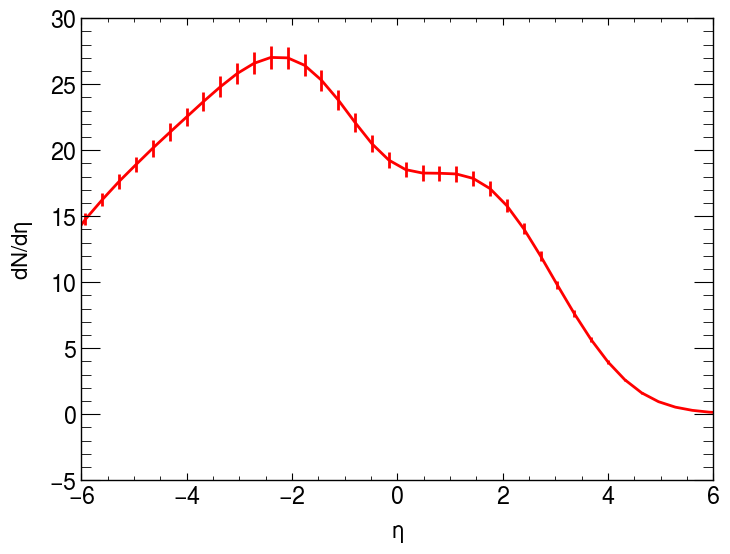

In [12]:
plot_dNdEta(m=0, n=5, eta_flat='1p3', eta_gw='1p3', event_range=[0, 1000],
                para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35",
                nsampling=2000,fontsize=16, 
                HWF_or_DWF='DWF', color='red')